#### 1. Import Libraries

In [27]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier


#### 2. Load User Features

In [28]:
# Load user behavior features từ bước Feature Engineering
user_features = pd.read_csv('user_behavior_features.csv')

print(f"Dataset shape: {user_features.shape}")
print(f"\nColumns ({len(user_features.columns)}):")
for i, col in enumerate(user_features.columns, 1):
    print(f"  {i}. {col}")

print(f"\nFirst 5 rows:")
display(user_features.head())

Dataset shape: (1123767, 13)

Columns (13):
  1. visitorid
  2. num_addtocart
  3. num_transaction
  4. num_view
  5. view2cart_rate
  6. cart2tran_rate
  7. view2tran_rate
  8. avg_view_before_buy
  9. num_session
  10. recency_days
  11. active_days
  12. session_per_day
  13. item_diversity

First 5 rows:


,visitorid,num_addtocart,num_transaction,num_view,view2cart_rate,cart2tran_rate,view2tran_rate,avg_view_before_buy,num_session,recency_days,active_days,session_per_day,item_diversity
0,1,0,0,1,0.0,0.0,0.0,1.0,1,3721,1,1.0,1
1,2,0,0,8,0.0,0.0,0.0,8.0,1,3727,1,1.0,4
2,3,0,0,1,0.0,0.0,0.0,1.0,1,3734,1,1.0,1
3,5,0,0,1,0.0,0.0,0.0,1.0,1,3749,1,1.0,1
4,7,0,0,3,0.0,0.0,0.0,3.0,2,3811,2,1.0,3


#### 3. Tạo Target Variable

TARGET VARIABLE ANALYSIS

Target distribution:
has_transaction
0    1114424
1       9343
Name: count, dtype: int64

Conversion rate: 0.83%
Total users: 1123767
Users with purchase: 9343
Users without purchase: 1114424


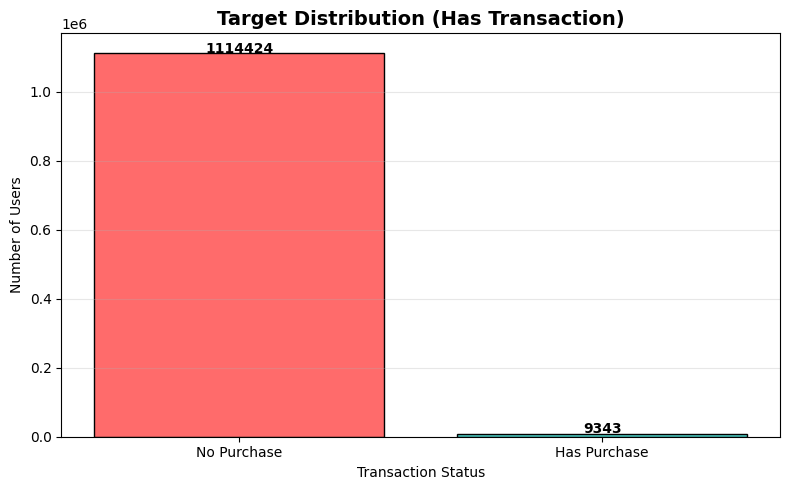

In [29]:
# Target: User có thực hiện transaction hay không (binary classification)
user_features['has_transaction'] = (user_features['num_transaction'] > 0).astype(int)

# Kiểm tra phân bố target
print("="*60)
print("TARGET VARIABLE ANALYSIS")
print("="*60)
print("\nTarget distribution:")
print(user_features['has_transaction'].value_counts())
print(f"\nConversion rate: {user_features['has_transaction'].mean():.2%}")
print(f"Total users: {len(user_features)}")
print(f"Users with purchase: {user_features['has_transaction'].sum()}")
print(f"Users without purchase: {(user_features['has_transaction']==0).sum()}")

# Visualize target distribution
plt.figure(figsize=(8, 5))
target_counts = user_features['has_transaction'].value_counts()
plt.bar(['No Purchase', 'Has Purchase'], target_counts.values, color=['#ff6b6b', '#4ecdc4'], edgecolor='black')
plt.title('Target Distribution (Has Transaction)', fontsize=14, fontweight='bold')
plt.xlabel('Transaction Status')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 100, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()



#### 4. Feature Selection & Preprocessing

In [30]:
# Chọn features cho model (loại bỏ ID, target, và datetime columns)
exclude_cols = ['visitorid', 'has_transaction', 'num_transaction', 'first_event', 'last_event']
feature_cols = [col for col in user_features.columns if col not in exclude_cols]

print(f"Selected features ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

# Prepare X and y
X = user_features[feature_cols].copy()
y = user_features['has_transaction']

# Xử lý missing values và inf
print(f"\nBefore cleaning:")
print(f"  Missing values: {X.isnull().sum().sum()}")
print(f"  Inf values: {np.isinf(X.values).sum()}")

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"\nAfter cleaning:")
print(f"  Missing values: {X.isnull().sum().sum()}")
print(f"  Inf values: {np.isinf(X.values).sum()}")

print(f"\nFinal shapes:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")


Selected features (11):
 1. num_addtocart
 2. num_view
 3. view2cart_rate
 4. cart2tran_rate
 5. view2tran_rate
 6. avg_view_before_buy
 7. num_session
 8. recency_days
 9. active_days
10. session_per_day
11. item_diversity

Before cleaning:
  Missing values: 0
  Inf values: 0

After cleaning:
  Missing values: 0
  Inf values: 0

Final shapes:
  X shape: (1123767, 11)
  y shape: (1123767,)


#### 5. Train-Test Split

In [31]:
# Split với stratified sampling để giữ tỷ lệ conversion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("="*60)
print("TRAIN-TEST SPLIT")
print("="*60)
print(f"\nTrain set size: {X_train.shape[0]} samples ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} samples ({X_test.shape[0]/X.shape[0]*100:.1f}%)")
print(f"\nTrain conversion rate: {y_train.mean():.2%}")
print(f"Test conversion rate: {y_test.mean():.2%}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data preprocessing complete!")
print("✓ Features standardized!")



TRAIN-TEST SPLIT

Train set size: 899013 samples (80.0%)
Test set size: 224754 samples (20.0%)

Train conversion rate: 0.83%
Test conversion rate: 0.83%

✓ Data preprocessing complete!
✓ Features standardized!


#### 6. Train Multiple Models

In [32]:
# Khởi tạo models với class balancing (vì data imbalanced)
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000, 
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced',
        max_depth=10,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, 
        random_state=42, 
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss'
    )
}

results = {}

print("="*60)
print("MODEL TRAINING & EVALUATION")
print("="*60)

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print('='*60)
    
    # Train model
    if model_name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Evaluate
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Purchase', 'Purchase']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"                 Predicted")
    print(f"               No    Yes")
    print(f"Actual No   {cm[0,0]:5d} {cm[0,1]:5d}")
    print(f"       Yes  {cm[1,0]:5d} {cm[1,1]:5d}")
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")
    
    # Average Precision (PR-AUC) - better for imbalanced data
    avg_precision = average_precision_score(y_test, y_pred_proba)
    print(f"Average Precision (PR-AUC): {avg_precision:.4f}")
    
    # Store results
    results[model_name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'confusion_matrix': cm
    }

print("\n" + "="*60)
print("✓ TRAINING COMPLETE!")
print("="*60)


MODEL TRAINING & EVALUATION

Training: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

 No Purchase       1.00      1.00      1.00    222885
    Purchase       1.00      1.00      1.00      1869

    accuracy                           1.00    224754
   macro avg       1.00      1.00      1.00    224754
weighted avg       1.00      1.00      1.00    224754


Confusion Matrix:
                 Predicted
               No    Yes
Actual No   222877     8
       Yes      0  1869

ROC-AUC Score: 1.0000
Average Precision (PR-AUC): 0.9994

Training: Random Forest

Classification Report:
              precision    recall  f1-score   support

 No Purchase       1.00      1.00      1.00    222885
    Purchase       1.00      1.00      1.00      1869

    accuracy                           1.00    224754
   macro avg       1.00      1.00      1.00    224754
weighted avg       1.00      1.00      1.00    224754


Confusion Matrix:
                 

#### 7. Model Comparison


MODEL PERFORMANCE COMPARISON
              Model  ROC-AUC   PR-AUC
Logistic Regression 0.999998 0.999445
      Random Forest 1.000000 1.000000
            XGBoost 1.000000 1.000000


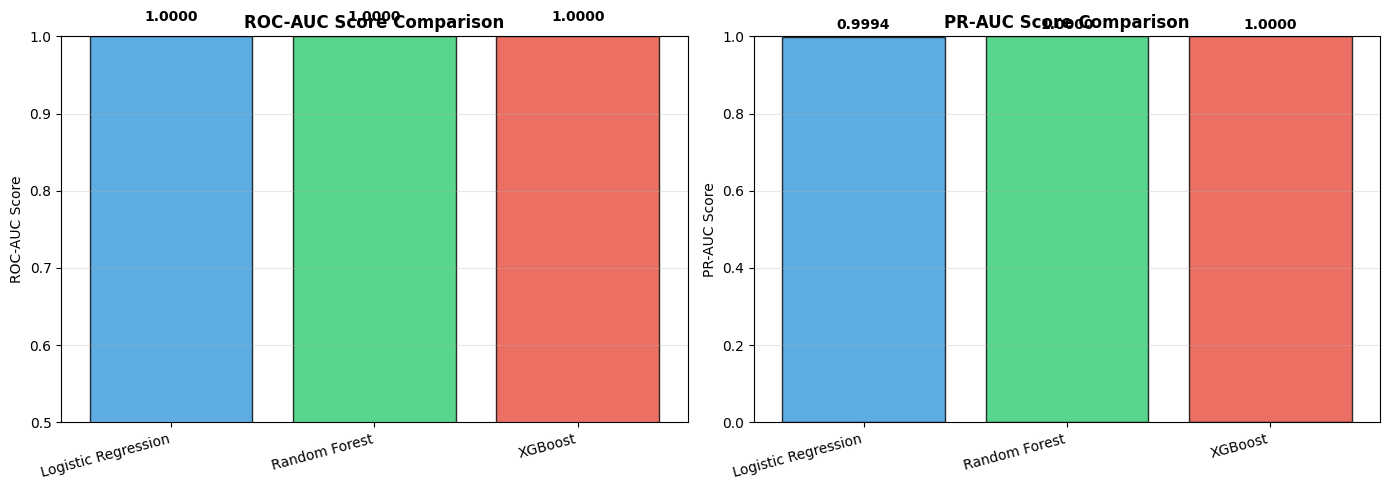


MODEL PERFORMANCE COMPARISON
              Model  ROC-AUC   PR-AUC
Logistic Regression 0.999998 0.999445
      Random Forest 1.000000 1.000000
            XGBoost 1.000000 1.000000


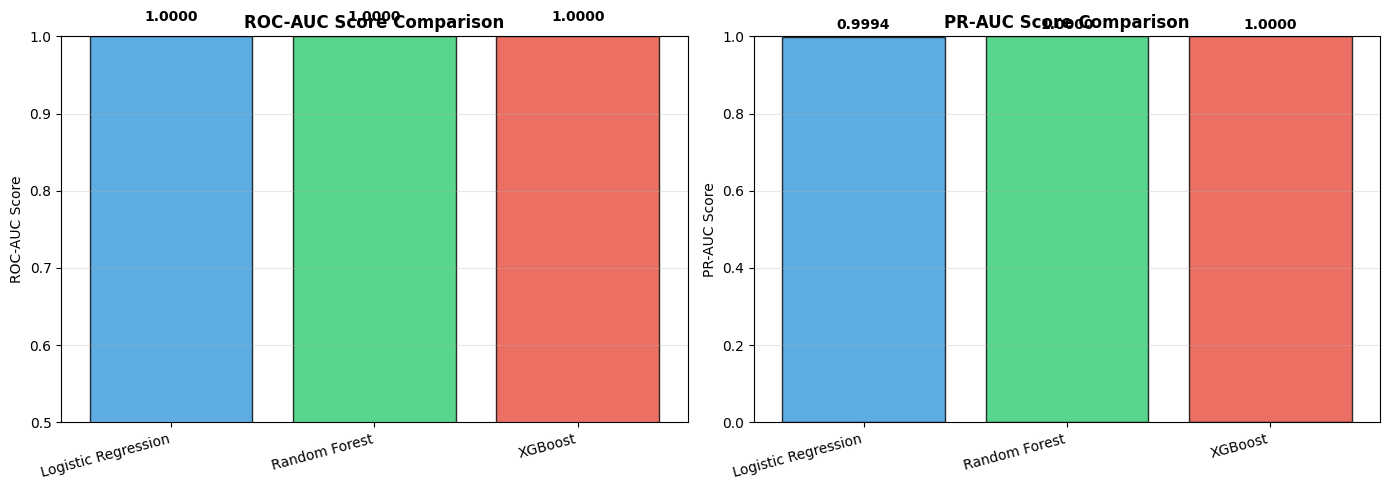

In [33]:
# So sánh performance các models
model_names = list(results.keys())
roc_aucs = [results[m]['roc_auc'] for m in model_names]
pr_aucs = [results[m]['avg_precision'] for m in model_names]

comparison_df = pd.DataFrame({
    'Model': model_names,
    'ROC-AUC': roc_aucs,
    'PR-AUC': pr_aucs
})

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

# Visualize comparison - FIXED VERSION
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC comparison
x_pos = np.arange(len(model_names))
axes[0].bar(x_pos, roc_aucs, 
            color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(model_names, rotation=15, ha='right')
axes[0].set_title('ROC-AUC Score Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylabel('ROC-AUC Score')
axes[0].set_ylim([0.5, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, score in enumerate(roc_aucs):
    axes[0].text(i, score + 0.02, f'{score:.4f}', ha='center', fontweight='bold')

# PR-AUC comparison
axes[1].bar(x_pos, pr_aucs, 
            color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(model_names, rotation=15, ha='right')
axes[1].set_title('PR-AUC Score Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('PR-AUC Score')
axes[1].set_ylim([0, 1.0])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, score in enumerate(pr_aucs):
    axes[1].text(i, score + 0.02, f'{score:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()
# So sánh performance các models
model_names = list(results.keys())
roc_aucs = [results[m]['roc_auc'] for m in model_names]
pr_aucs = [results[m]['avg_precision'] for m in model_names]

comparison_df = pd.DataFrame({
    'Model': model_names,
    'ROC-AUC': roc_aucs,
    'PR-AUC': pr_aucs
})

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

# Visualize comparison - FIXED VERSION
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC comparison
x_pos = np.arange(len(model_names))
axes[0].bar(x_pos, roc_aucs, 
            color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(model_names, rotation=15, ha='right')
axes[0].set_title('ROC-AUC Score Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylabel('ROC-AUC Score')
axes[0].set_ylim([0.5, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, score in enumerate(roc_aucs):
    axes[0].text(i, score + 0.02, f'{score:.4f}', ha='center', fontweight='bold')

# PR-AUC comparison
axes[1].bar(x_pos, pr_aucs, 
            color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='black', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(model_names, rotation=15, ha='right')
axes[1].set_title('PR-AUC Score Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('PR-AUC Score')
axes[1].set_ylim([0, 1.0])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, score in enumerate(pr_aucs):
    axes[1].text(i, score + 0.02, f'{score:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()



#### 8. Best Model Analysis

In [34]:
# Chọn best model dựa trên ROC-AUC
best_model_name = max(results.keys(), key=lambda x: results[x]['roc_auc'])
best_model = results[best_model_name]['model']

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*60}")
print(f"ROC-AUC Score: {results[best_model_name]['roc_auc']:.4f}")
print(f"PR-AUC Score: {results[best_model_name]['avg_precision']:.4f}")
print('='*60)



BEST MODEL: Random Forest
ROC-AUC Score: 1.0000
PR-AUC Score: 1.0000


#### 9. Feature Importance (Best Model)


FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
            feature  importance
     cart2tran_rate    0.365819
     view2tran_rate    0.297872
     view2cart_rate    0.189264
      num_addtocart    0.087052
           num_view    0.019730
avg_view_before_buy    0.018757
        num_session    0.014749
     item_diversity    0.006092
    session_per_day    0.000508
        active_days    0.000103
       recency_days    0.000054


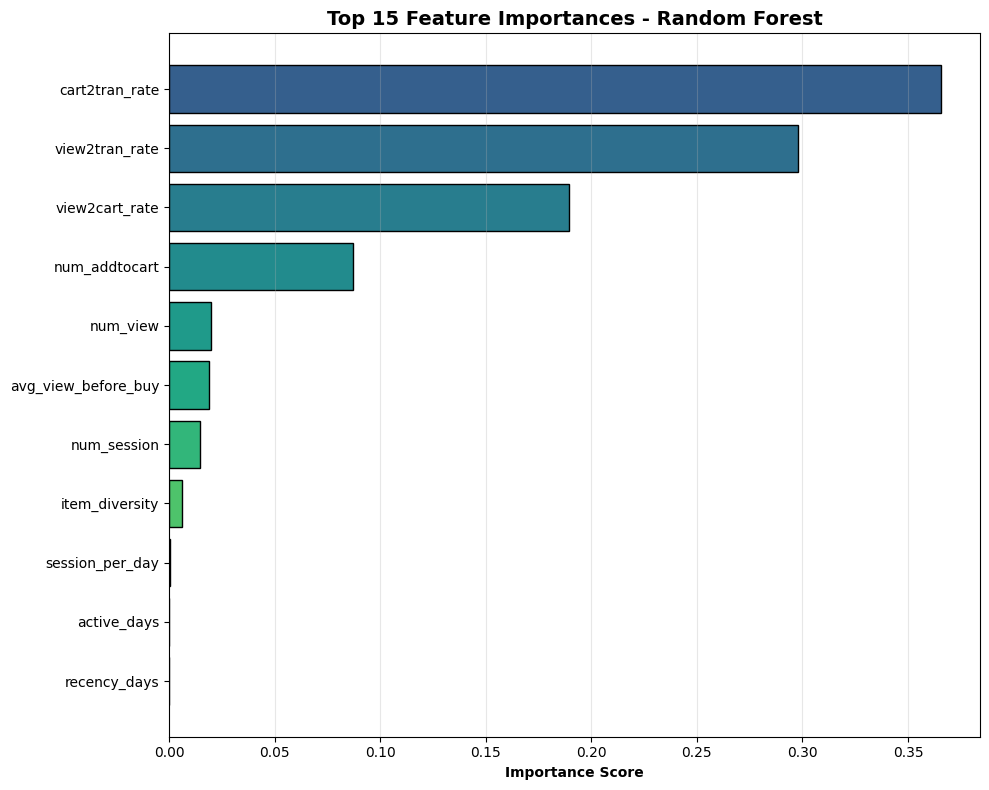

In [35]:
# Feature importance (chỉ có cho tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)
    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
    
    plt.barh(range(len(top_features)), top_features['importance'], color=colors, edgecolor='black')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance Score', fontweight='bold')
    plt.title(f'Top 15 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(f"\n⚠ Feature importance not available for {best_model_name}")
    print("Only tree-based models (Random Forest, XGBoost) have feature_importances_")



#### 10. ROC Curve & Precision-Recall Curve

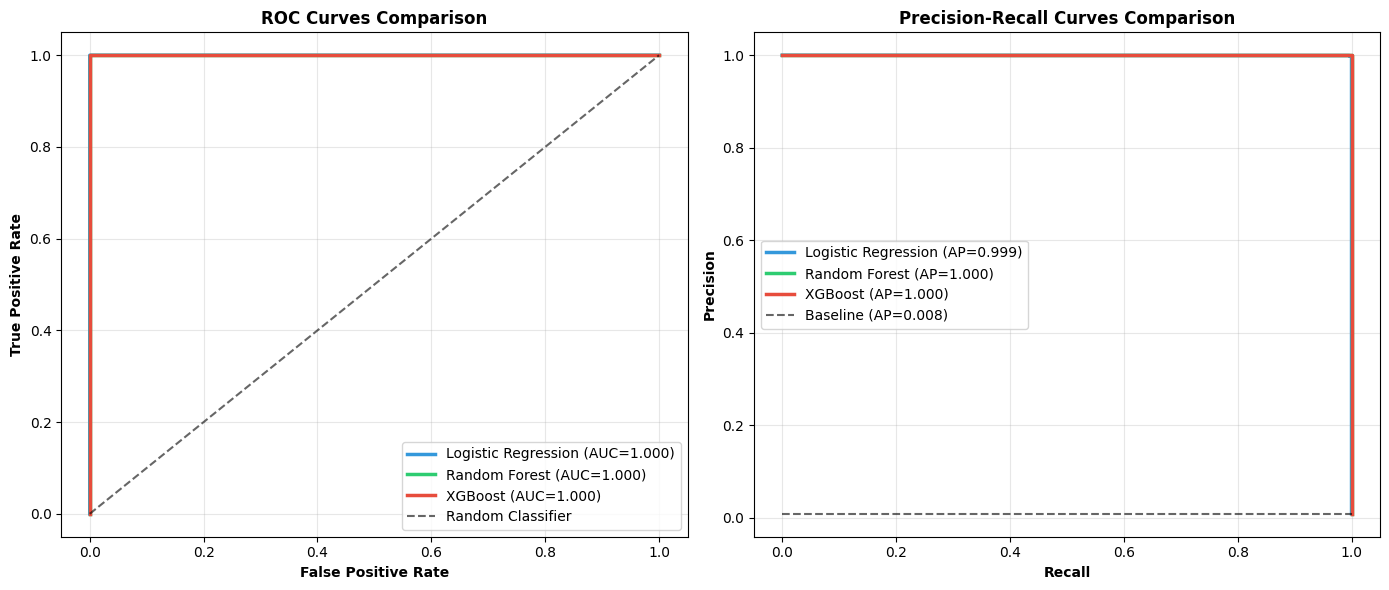

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
colors = ['#3498db', '#2ecc71', '#e74c3c']
for i, model_name in enumerate(results.keys()):
    fpr, tpr, _ = roc_curve(y_test, results[model_name]['y_pred_proba'])
    roc_auc = results[model_name]['roc_auc']
    axes[0].plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc:.3f})', 
                 linewidth=2.5, color=colors[i])

axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5, alpha=0.6)
axes[0].set_xlabel('False Positive Rate', fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontweight='bold')
axes[0].set_title('ROC Curves Comparison', fontsize=12, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
for i, model_name in enumerate(results.keys()):
    precision, recall, _ = precision_recall_curve(y_test, results[model_name]['y_pred_proba'])
    pr_auc = results[model_name]['avg_precision']
    axes[1].plot(recall, precision, label=f'{model_name} (AP={pr_auc:.3f})', 
                 linewidth=2.5, color=colors[i])

# Baseline
baseline = y_test.values.mean()
axes[1].plot([0, 1], [baseline, baseline], 'k--', 
             label=f'Baseline (AP={baseline:.3f})', linewidth=1.5, alpha=0.6)

axes[1].set_xlabel('Recall', fontweight='bold')
axes[1].set_ylabel('Precision', fontweight='bold')
axes[1].set_title('Precision-Recall Curves Comparison', fontsize=12, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



#### 11. Confusion Matrix Visualization

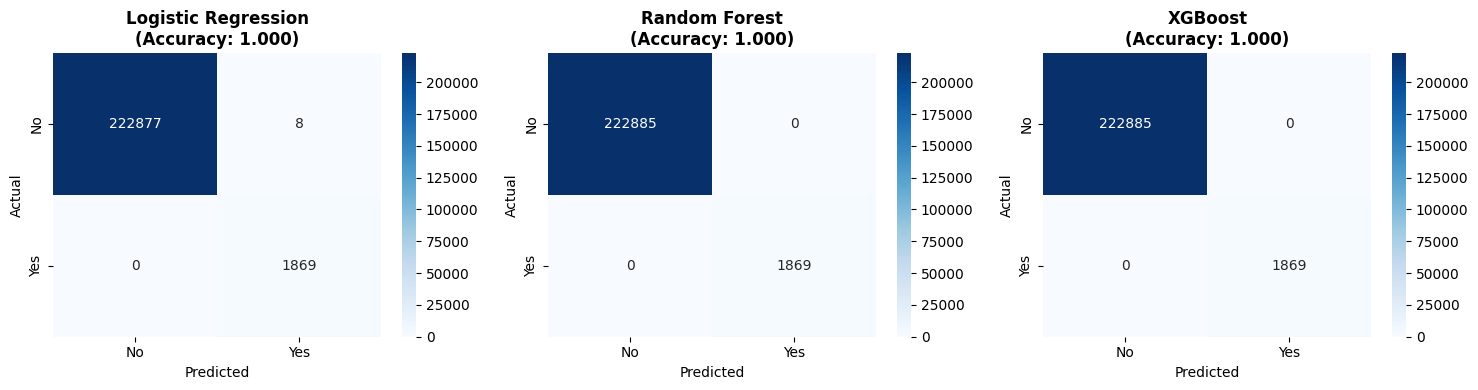

In [38]:
# Visualize confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (model_name, result) in enumerate(results.items()):
    cm = result['confusion_matrix']
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
                ax=axes[idx], cbar=True)
    
    axes[idx].set_title(f'{model_name}\n(Accuracy: {(cm[0,0]+cm[1,1])/cm.sum():.3f})', 
                       fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()


#### 12. Real-time Prediction Function

In [39]:
# Save best model
with open('conversion_prediction_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save feature columns
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

# Save all results
with open('all_models_results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Save predictions
predictions_df = pd.DataFrame({
    'visitorid': user_features.loc[X_test.index, 'visitorid'].values,
    'actual': y_test.values,
    'predicted': results[best_model_name]['y_pred'],
    'probability': results[best_model_name]['y_pred_proba']
})
predictions_df.to_csv('conversion_predictions.csv', index=False)

print("\n" + "="*60)
print("SAVED FILES")
print("="*60)
print("✓ conversion_prediction_model.pkl")
print("✓ scaler.pkl")
print("✓ feature_columns.pkl")
print("✓ all_models_results.pkl")
print("✓ conversion_predictions.csv")

print("\nPredictions preview:")
display(predictions_df.head(10))



SAVED FILES
✓ conversion_prediction_model.pkl
✓ scaler.pkl
✓ feature_columns.pkl
✓ all_models_results.pkl
✓ conversion_predictions.csv

Predictions preview:


,visitorid,actual,predicted,probability
0,799884,0,0,0.0
1,446452,0,0,0.0
2,1398205,0,0,0.0
3,327945,0,0,0.0
4,1015690,0,0,0.0
5,1025997,0,0,0.0
6,617129,0,0,0.0
7,953855,0,0,0.0
8,322774,0,0,0.0
9,660653,0,0,0.0


#### 13. Real-time Prediction Function

In [41]:
def predict_user_conversion(user_id, user_features_df):
    """
    Dự đoán xác suất conversion cho 1 user cụ thể
    
    Parameters:
    - user_id: ID của user
    - user_features_df: DataFrame chứa user features
    
    Returns:
    - conversion_probability: Xác suất user sẽ mua hàng
    - status: Success/Error message
    """
    try:
        # Load model & scaler
        with open('conversion_prediction_model.pkl', 'rb') as f:
            model = pickle.load(f)
        with open('scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        with open('feature_columns.pkl', 'rb') as f:
            feature_cols = pickle.load(f)
        
        # Get user data
        user_data = user_features_df[user_features_df['visitorid'] == user_id]
        
        if len(user_data) == 0:
            return None, "User not found"
        
        # Prepare features
        X_user = user_data[feature_cols].values
        X_user = np.nan_to_num(X_user, nan=0, posinf=0, neginf=0)
        
        # Scale features (nếu model cần scaling)
        if best_model_name == 'Logistic Regression':
            X_user = scaler.transform(X_user)
        
        # Predict
        conversion_prob = model.predict_proba(X_user)[0][1]
        
        return conversion_prob, "Success"
    
    except Exception as e:
        return None, f"Error: {str(e)}"

# Test function với 3 users
print("\n" + "="*60)
print("REAL-TIME PREDICTION TEST")
print("="*60)

sample_users = user_features['visitorid'].sample(3, random_state=42).values

for user_id in sample_users:
    prob, status = predict_user_conversion(user_id, user_features)
    actual = user_features[user_features['visitorid']==user_id]['has_transaction'].values[0]
    
    print(f"\nUser ID: {user_id}")
    if prob is not None:
        print(f"  Predicted Probability: {float(prob):.2%}")
    else:
        print(f"  Predicted Probability: N/A")
    print(f"  Actual Purchase: {'Yes' if actual==1 else 'No'}")
    print(f"  Status: {status}")




REAL-TIME PREDICTION TEST

User ID: 7763
  Predicted Probability: 0.00%
  Actual Purchase: No
  Status: Success

User ID: 912777
  Predicted Probability: 0.00%
  Actual Purchase: No
  Status: Success

User ID: 1318768
  Predicted Probability: 0.00%
  Actual Purchase: No
  Status: Success


#### 14. Summary & Insights

In [42]:
print("\n" + "="*60)
print("CONVERSION PREDICTION MODEL - FINAL SUMMARY")
print("="*60)

print(f"\n1. BEST MODEL")
print(f"   Model: {best_model_name}")
print(f"   ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"   PR-AUC: {results[best_model_name]['avg_precision']:.4f}")

print(f"\n2. DATASET STATISTICS")
print(f"   Total users: {len(user_features):,}")
print(f"   Users with purchase: {y.sum():,} ({y.mean():.2%})")
print(f"   Users without purchase: {(y==0).sum():,} ({(y==0).mean():.2%})")
print(f"   Features used: {len(feature_cols)}")

print(f"\n3. MODEL PERFORMANCE")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")

# Show all models comparison
print(f"\n4. ALL MODELS COMPARISON")
print(comparison_df.to_string(index=False))

if hasattr(best_model, 'feature_importances_'):
    top_5_features = feature_importance.head(5)
    print(f"\n5. TOP 5 MOST IMPORTANT FEATURES")
    for i, row in top_5_features.iterrows():
        print(f"   {row['feature']}: {row['importance']:.4f}")

print("\n" + "="*60)
print("✓ CONVERSION PREDICTION MODEL COMPLETE!")
print("="*60)

print("\n📊 Use Cases:")
print("  1. Predict real-time conversion probability for any user")
print("  2. Segment users by purchase likelihood")
print("  3. Target high-probability users for marketing")
print("  4. Optimize conversion funnel")
print("  5. A/B testing and experimentation")



CONVERSION PREDICTION MODEL - FINAL SUMMARY

1. BEST MODEL
   Model: Random Forest
   ROC-AUC: 1.0000
   PR-AUC: 1.0000

2. DATASET STATISTICS
   Total users: 1,123,767
   Users with purchase: 9,343 (0.83%)
   Users without purchase: 1,114,424 (99.17%)
   Features used: 11

3. MODEL PERFORMANCE
   Training samples: 899,013
   Test samples: 224,754

4. ALL MODELS COMPARISON
              Model  ROC-AUC   PR-AUC
Logistic Regression 0.999998 0.999445
      Random Forest 1.000000 1.000000
            XGBoost 1.000000 1.000000

5. TOP 5 MOST IMPORTANT FEATURES
   cart2tran_rate: 0.3658
   view2tran_rate: 0.2979
   view2cart_rate: 0.1893
   num_addtocart: 0.0871
   num_view: 0.0197

✓ CONVERSION PREDICTION MODEL COMPLETE!

📊 Use Cases:
  1. Predict real-time conversion probability for any user
  2. Segment users by purchase likelihood
  3. Target high-probability users for marketing
  4. Optimize conversion funnel
  5. A/B testing and experimentation
